In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


device(type='cuda', index=0)

In [110]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [2]:
Real = pd.read_csv("/kaggle/input/fake-news-detection/true.csv")
Real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
Real['Class'] = 'Real'

In [4]:
Real.head()

,title,text,subject,date,Class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real


In [5]:
Fake = pd.read_csv("/kaggle/input/fake-news-detection/fake.csv")
Fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
Fake['Class'] = 'Fake'
Fake.head()

,title,text,subject,date,Class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


# **1st 2k Data from Fake**

In [115]:
Fake = Fake[:2000]

# **1st 2k Data from True**

In [116]:
Real = Real[:2000]

# **Concatenate Two DataFrames**

In [117]:
# Concatenate the DataFrames along the rows (axis=0)
df = pd.concat([Real,Fake], ignore_index=True)
df.head()

,title,text,subject,date,Class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real


In [118]:
df=df.dropna()

In [119]:
df.shape

(4000, 5)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4000 non-null   object
 1   text     4000 non-null   object
 2   subject  4000 non-null   object
 3   date     4000 non-null   object
 4   Class    4000 non-null   object
dtypes: object(5)
memory usage: 156.4+ KB


In [121]:
df['Class'].value_counts()

Class
Real    2000
Fake    2000
Name: count, dtype: int64

# **Data Distribution**

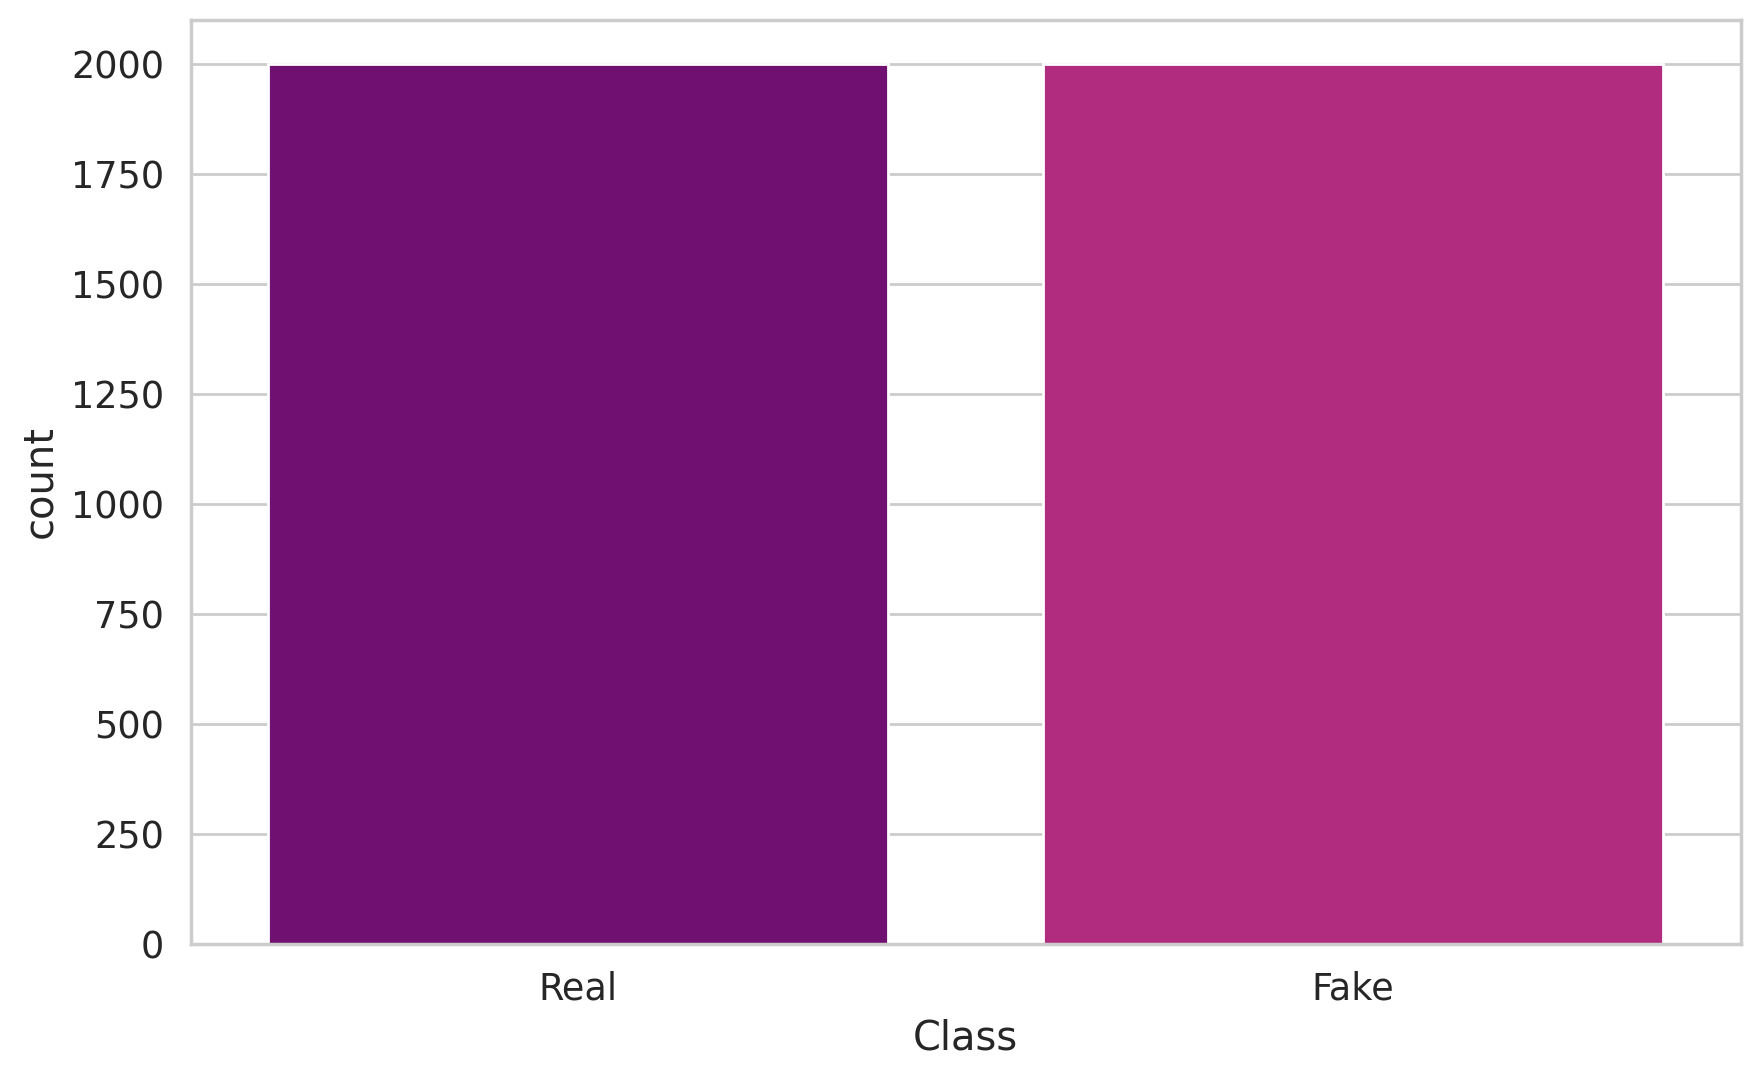

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))
class_names = ['Real', 'Fake']
custom_palette = ['Purple', 'MediumVioletRed', 'teal']

sns.countplot(x='Class', data=df, palette=custom_palette)

plt.gca().set_xticklabels(class_names)

plt.show()


In [123]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def visualize_text_data(data, title):
    # Calculate text length for each entry in the 'review' column and store the results in a new column
    data['text_length'] = data['text'].apply(len)
    
    # Calculate word count for each entry in the 'review' column and store the results in a new column
    data['news_word_count'] = data['text'].apply(lambda x: len(str(x).split()))

    # Create a figure with a larger size
    plt.figure(figsize=(16, 8))

    # Define a custom font with a nice appearance
    custom_font = FontProperties(family='serif', style='normal', size=14, weight='bold')

    # First subplot for text length distribution
    plt.subplot(1, 2, 1)
    plt.hist(data['text_length'], bins=10, color='mediumaquamarine', edgecolor='black', alpha=0.9, label='News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Text Length", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')
    plt.title(f'Text Length Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Second subplot for word count distribution
    plt.subplot(1, 2, 2)
    plt.hist(data['news_word_count'], bins=10, color='violet', edgecolor='black', alpha=0.9, label='News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Word Count", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')
    plt.title(f'Word Count Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Adjust the layout for subplots
    plt.tight_layout()

    # Show the plot
    plt.show()




In [144]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def visualize_text_data(data, title):
    # Calculate text length for each entry in the 'text' column and store the results in a new column
    data['text_length'] = data['text'].apply(len)
    
    # Calculate word count for each entry in the 'text' column and store the results in a new column
    data['news_word_count'] = data['text'].apply(lambda x: len(str(x).split()))

    # Create a figure with a larger size
    plt.figure(figsize=(16, 8))

    # Define a custom font with a nice appearance
    custom_font = FontProperties(family='serif', style='normal', size=14, weight='bold')

    # First subplot for text length distribution
    plt.subplot(1, 2, 1)
    n, bins, patches = plt.hist(data['text_length'], bins=10, color='mediumaquamarine', edgecolor='black', alpha=0.5, label='News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Text Length", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')
    plt.title(f'Text Length Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Annotate the plot with bin values (vertical text)
    for bin_val, freq in zip(bins, n):
        plt.text(bin_val+100, freq+20, f'{int(freq)}', ha='left', va='baseline', fontsize=12, fontproperties=custom_font)

    # Second subplot for word count distribution
    plt.subplot(1, 2, 2)
    n, bins, patches = plt.hist(data['news_word_count'], bins=10, color='violet', edgecolor='black', alpha=0.7, label='News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Word Count", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')
    plt.title(f'Word Count Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Annotate the plot with bin values (vertical text)
    for bin_val, freq in zip(bins, n):
        
        plt.text(bin_val+20, freq+20, f'{int(freq)}', ha='left', va='baseline', fontsize=12, fontproperties=custom_font)

    # Adjust the layout for subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# visualize_text_data(your_data_frame, "Your Title")


# **Visualize Text Data**

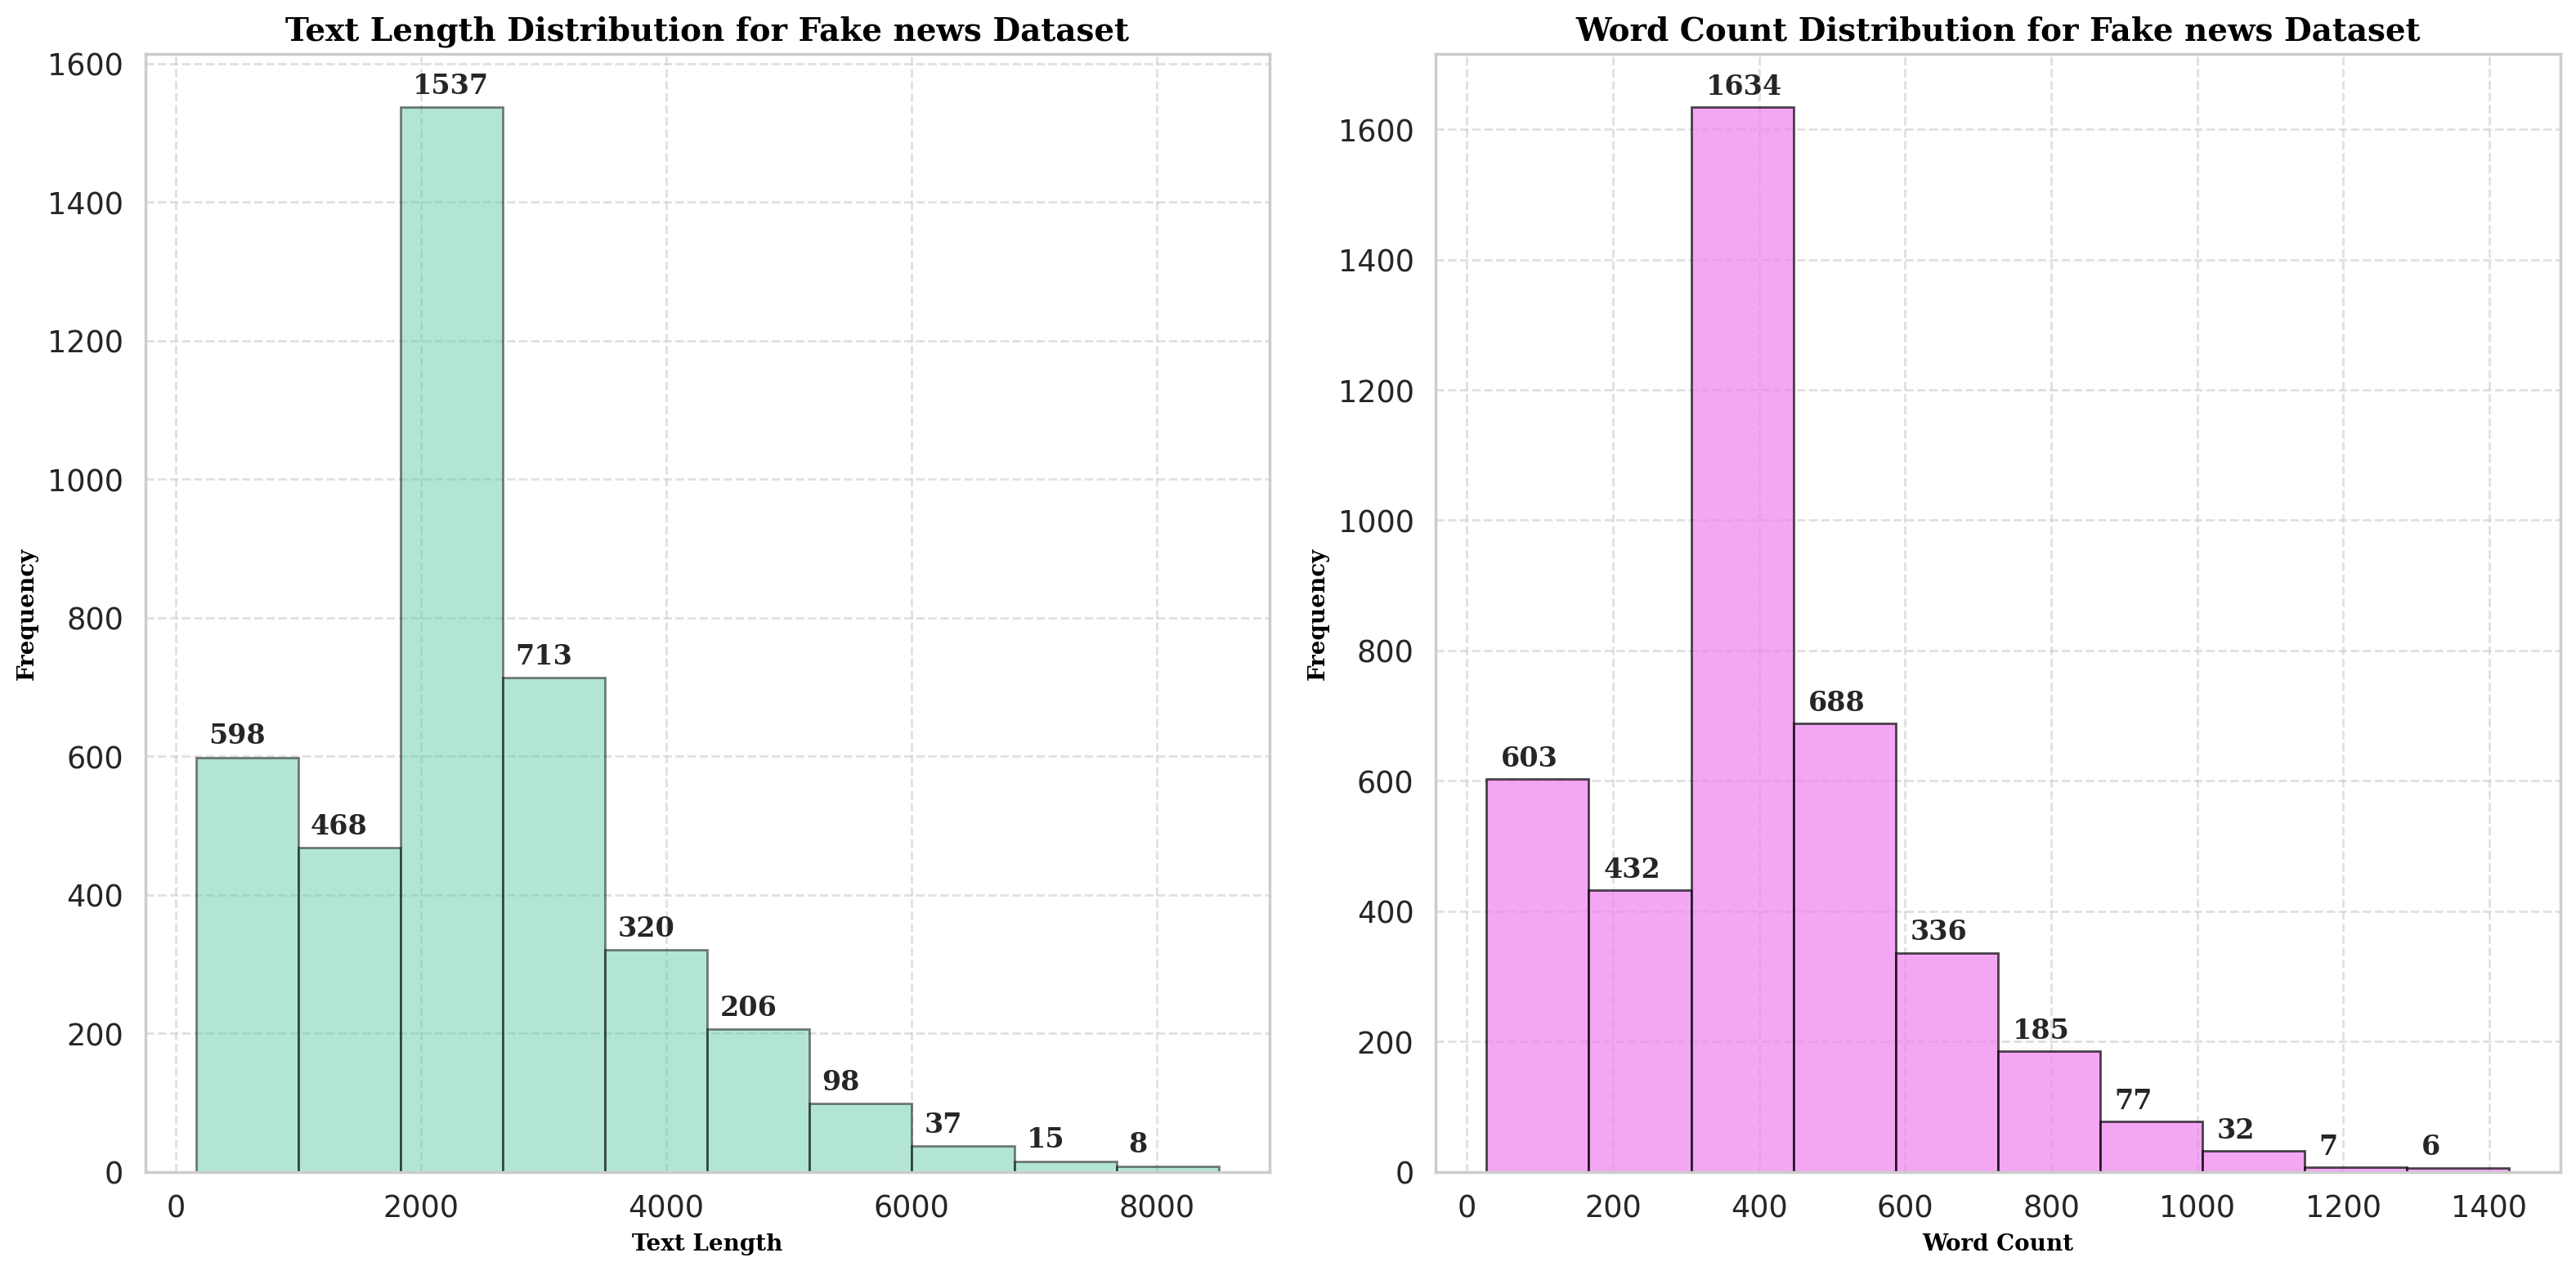

In [145]:
visualize_text_data(df, 'Fake news Dataset')

In [146]:
'''colormap = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r',
'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r',
'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r',
'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn',
'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r',
'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth',
'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r',
'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r',
'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic',
'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight',
'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']'''


from wordcloud import WordCloud

def create_wordcloud(data, column, title):
    # Specify a Bangla-supported font, such as "Siyam Rupali"



    #This setting disables the detection of collocations (multi-word phrases) to focus on individual words.
    wordcloud = WordCloud(width=800, height=400, background_color='black', #black
                          colormap='PuBu_r', collocations=False).generate(' '.join(data[column]))

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {column} in {title}', fontsize=16, color='black')
    plt.axis('off')
    plt.show()

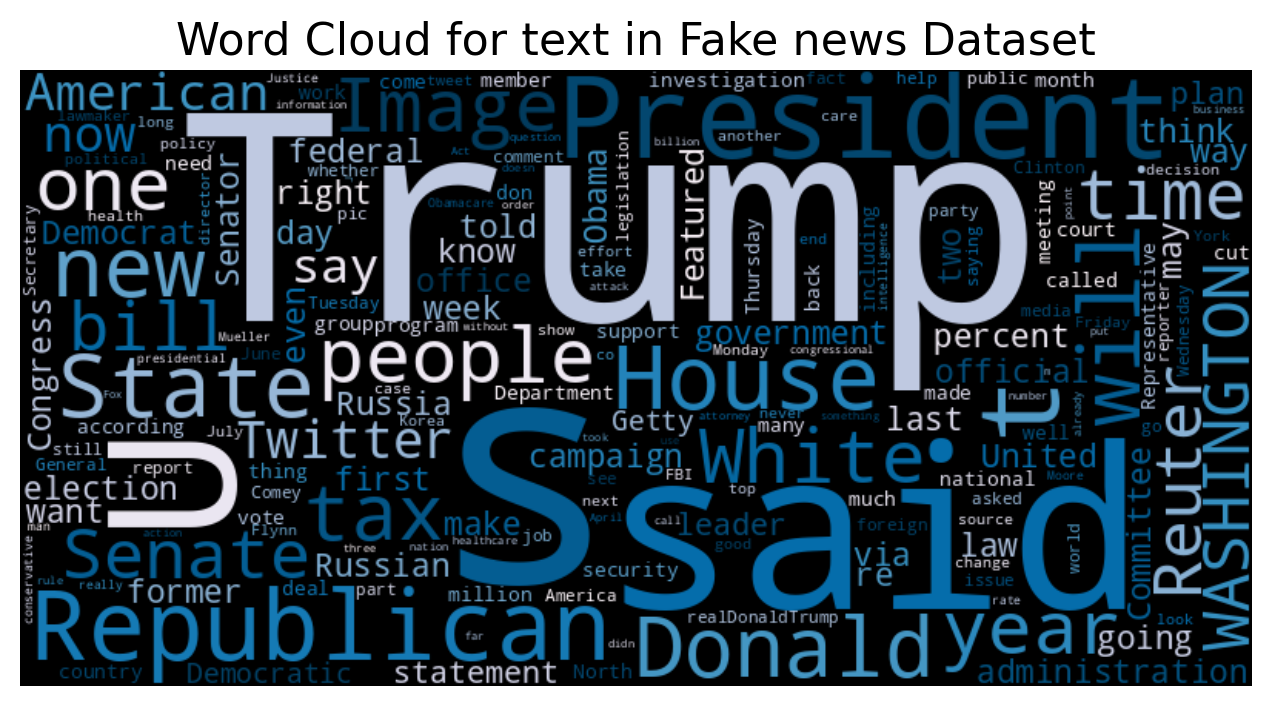

In [147]:
create_wordcloud(df, 'text', 'Fake news Dataset')

In [177]:
import pandas as pd

# Create a dictionary to map the class names to integers
class_to_int = {
    "Fake":0,
    "Real":1,
}

# Replace the class names in the DataFrame
df['Class'] = df['Class'].replace(class_to_int)

In [178]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [179]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased' 

In [180]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [181]:
sample_txt = 'Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday.'

In [182]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday.
   Tokens: ['Trump', 'campaign', 'ad', '##viser', 'George', 'Papa', '##do', '##pou', '##los', 'told', 'an', 'Australian', 'diplomat', 'in', 'May', '2016', 'that', 'Russia', 'had', 'political', 'dir', '##t', 'on', 'Democratic', 'presidential', 'candidate', 'Hillary', 'Clinton', ',', 'the', 'New', 'York', 'Times', 'reported', 'on', 'Saturday', '.']
Token IDs: [29846, 17323, 10840, 54478, 10955, 17429, 10317, 73535, 13788, 21937, 10151, 12829, 45652, 10106, 10725, 10255, 10189, 14664, 10374, 13736, 15895, 10123, 10135, 19281, 36476, 22102, 72734, 24139, 117, 10105, 10287, 10482, 12020, 15943, 10135, 24848, 119]


In [183]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [184]:
token_lens = []

for txt in df.text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512,truncation=True)
      token_lens.append(len(tokens))

In [185]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

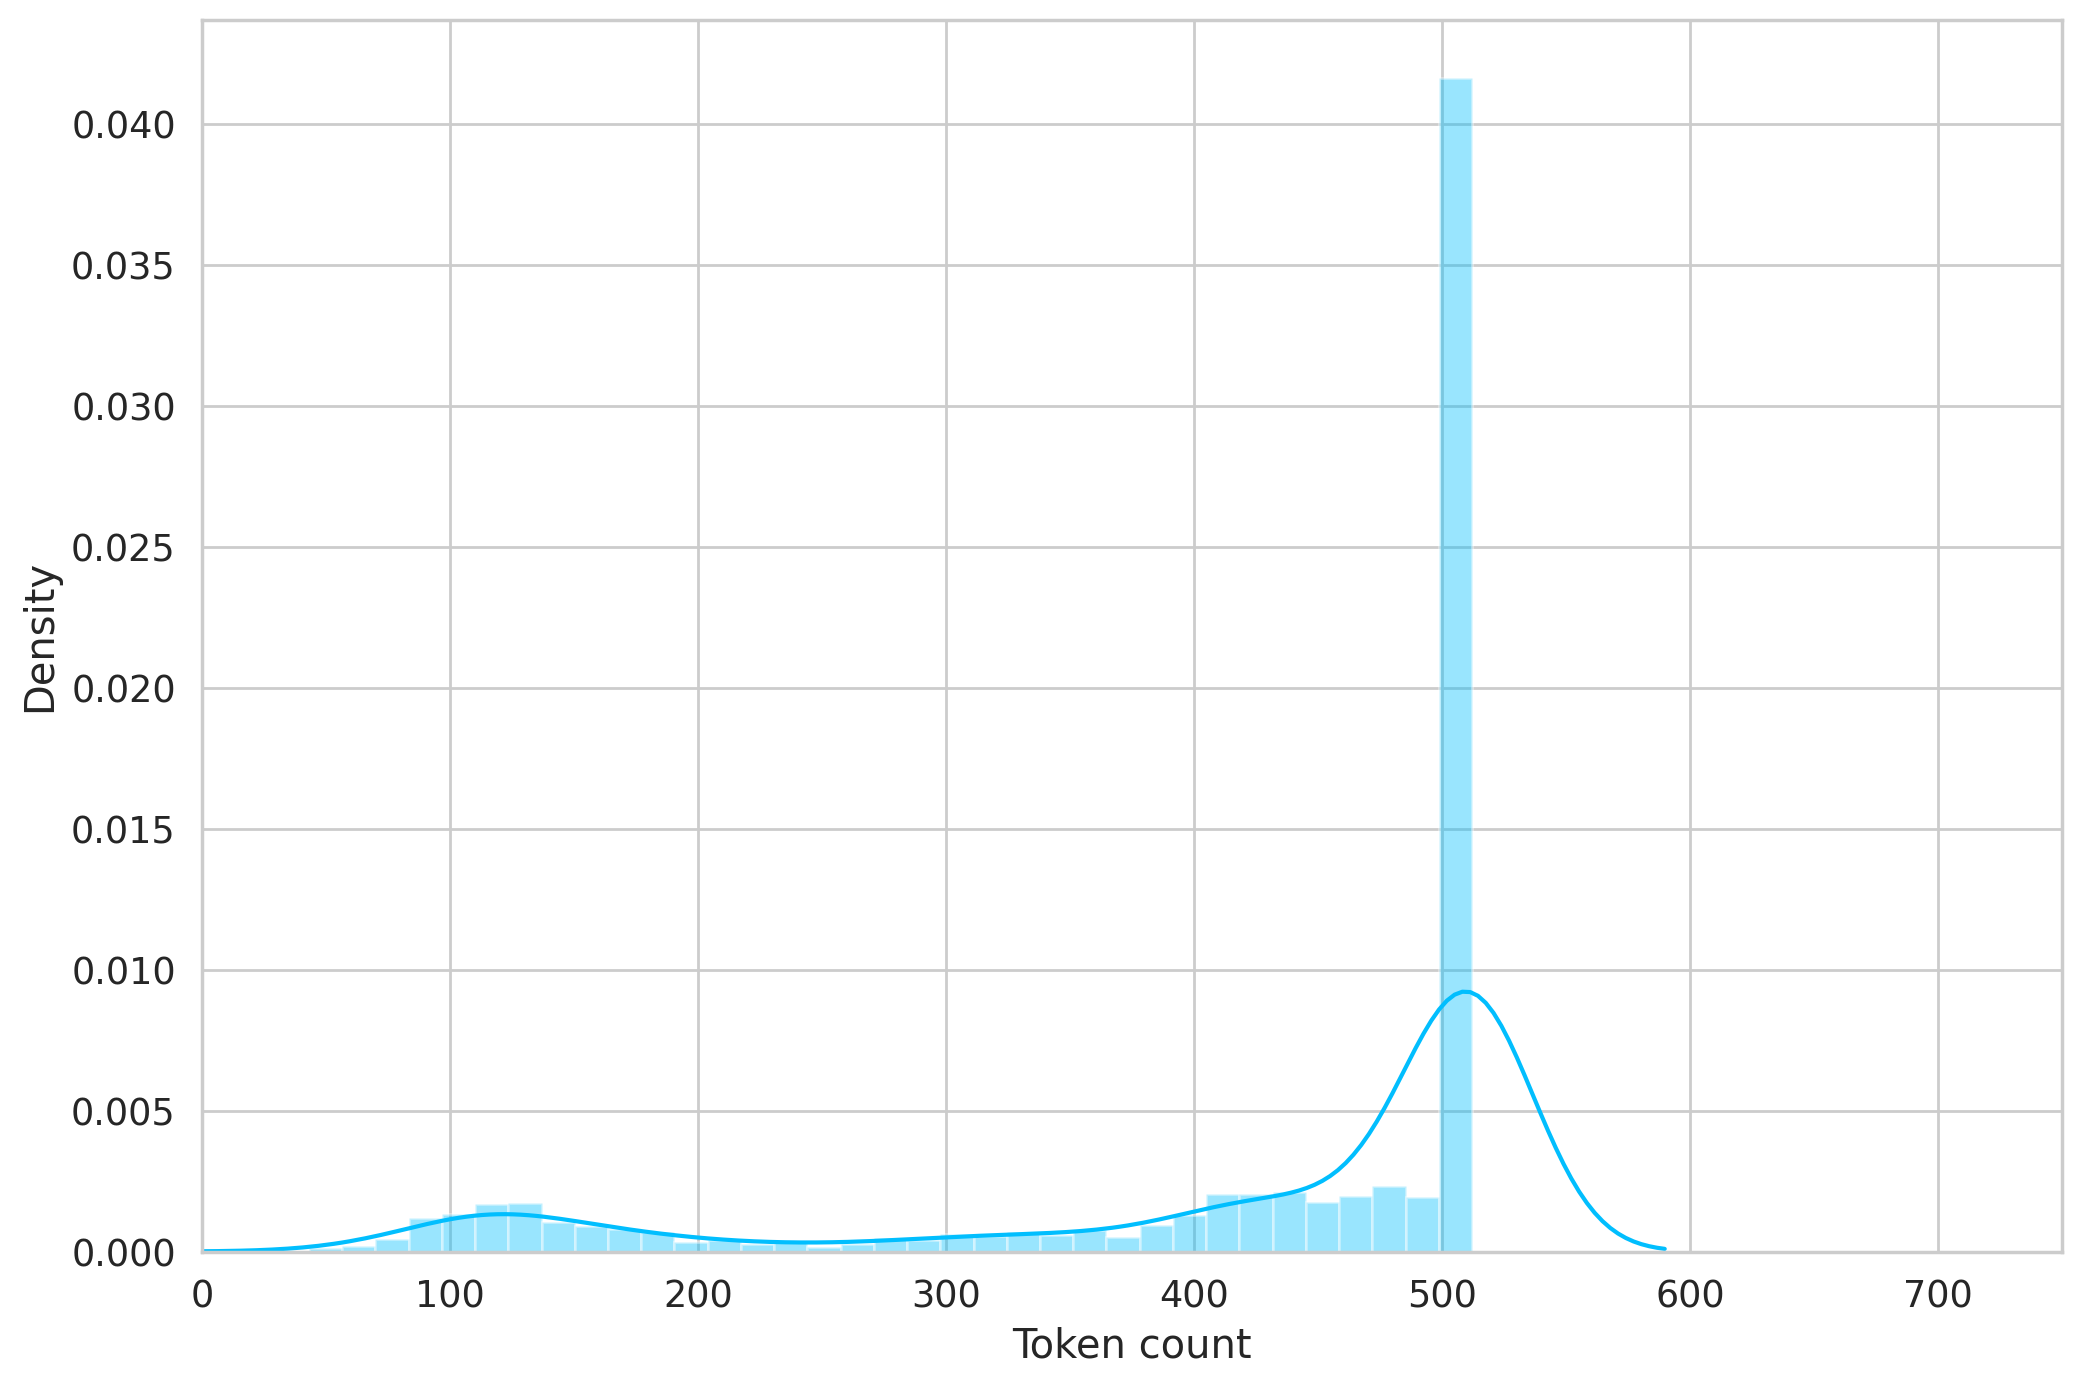

In [186]:
sns.distplot(token_lens)
plt.xlim([0, 750]);
plt.xlabel('Token count');

In [187]:
selected_columns = ['text', 'Class']
df = df[selected_columns]

In [188]:
MAX_LEN = 512

In [205]:
class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [206]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [207]:
df_train.shape, df_val.shape, df_test.shape

((2800, 2), (600, 2), (600, 2))

In [208]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.text.to_numpy(),
    targets=df.Class.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [209]:
import warnings

# Ignore the specific FutureWarning related to truncation
warnings.filterwarnings("ignore", message="Truncation was not explicitly activated*")

In [210]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [212]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [213]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [214]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [215]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [219]:
class FakenewsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(FakenewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [220]:
model = FakenewsClassifier(2)
model = model.to(device)

In [221]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [222]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5603, 0.4397],
        [0.6023, 0.3977],
        [0.5102, 0.4898],
        [0.4974, 0.5026],
        [0.4730, 0.5270],
        [0.5661, 0.4339],
        [0.6004, 0.3996],
        [0.5533, 0.4467]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# ***Training***

In [223]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [224]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring
    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update tqdm description with the current loss
        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [225]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    
    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [226]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [227]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.29batch/s, loss=0.0966]


Train loss 0.09655631681731652 accuracy 0.9717857142857143


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  7.00batch/s, loss=0.000488]


Val   loss 0.0004883378726663068 accuracy 1.0

Epoch 2/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.30batch/s, loss=0.00613]


Train loss 0.00613294224053139 accuracy 0.9989285714285714


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  7.04batch/s, loss=3.78e-5]


Val   loss 3.778444118021677e-05 accuracy 1.0

Epoch 3/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.30batch/s, loss=0.00224]


Train loss 0.0022440739831238584 accuracy 0.9996428571428572


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  7.02batch/s, loss=2.15e-5]


Val   loss 2.1530864275215813e-05 accuracy 1.0

Epoch 4/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.30batch/s, loss=0.00511] 


Train loss 0.005107775731807383 accuracy 0.9992857142857143


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  7.03batch/s, loss=2e-5]   


Val   loss 1.998926372228501e-05 accuracy 1.0

Epoch 5/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.30batch/s, loss=2.23e-5]


Train loss 2.2320024649421352e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  7.05batch/s, loss=1.38e-5]


Val   loss 1.3824598463543225e-05 accuracy 1.0

Epoch 6/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.30batch/s, loss=0.0114] 


Train loss 0.011394245758518601 accuracy 0.9985714285714286


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  7.03batch/s, loss=0.000596]


Val   loss 0.0005962132831336931 accuracy 1.0

Epoch 7/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.30batch/s, loss=7.29e-5] 


Train loss 7.289038368721126e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  6.98batch/s, loss=1.81e-5]


Val   loss 1.8067383862216957e-05 accuracy 1.0

Epoch 8/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.29batch/s, loss=2.29e-5]


Train loss 2.2882266535556743e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  7.05batch/s, loss=1.4e-5] 


Val   loss 1.3986128275670731e-05 accuracy 1.0

Epoch 9/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.30batch/s, loss=1.91e-5]


Train loss 1.9139505672813228e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:11<00:00,  6.82batch/s, loss=1.24e-5]


Val   loss 1.2386164222940957e-05 accuracy 1.0

Epoch 10/10
----------


Training: 100%|██████████| 350/350 [02:32<00:00,  2.30batch/s, loss=1.79e-5]


Train loss 1.7871745728500952e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:10<00:00,  7.05batch/s, loss=1.19e-5]

Val   loss 1.1882908790236494e-05 accuracy 1.0

CPU times: user 26min 46s, sys: 18.6 s, total: 27min 5s
Wall time: 27min 12s


# **Evaluation**

In [228]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [229]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 75/75 [00:10<00:00,  6.91batch/s, loss=0.0155]  


0.9983333333333334

In [230]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [231]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# **Classification report**

In [232]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

        Real     1.0000    0.9967    0.9984       305
        Fake     0.9966    1.0000    0.9983       295

    accuracy                         0.9983       600
   macro avg     0.9983    0.9984    0.9983       600
weighted avg     0.9983    0.9983    0.9983       600



# **Confusion Matrix**

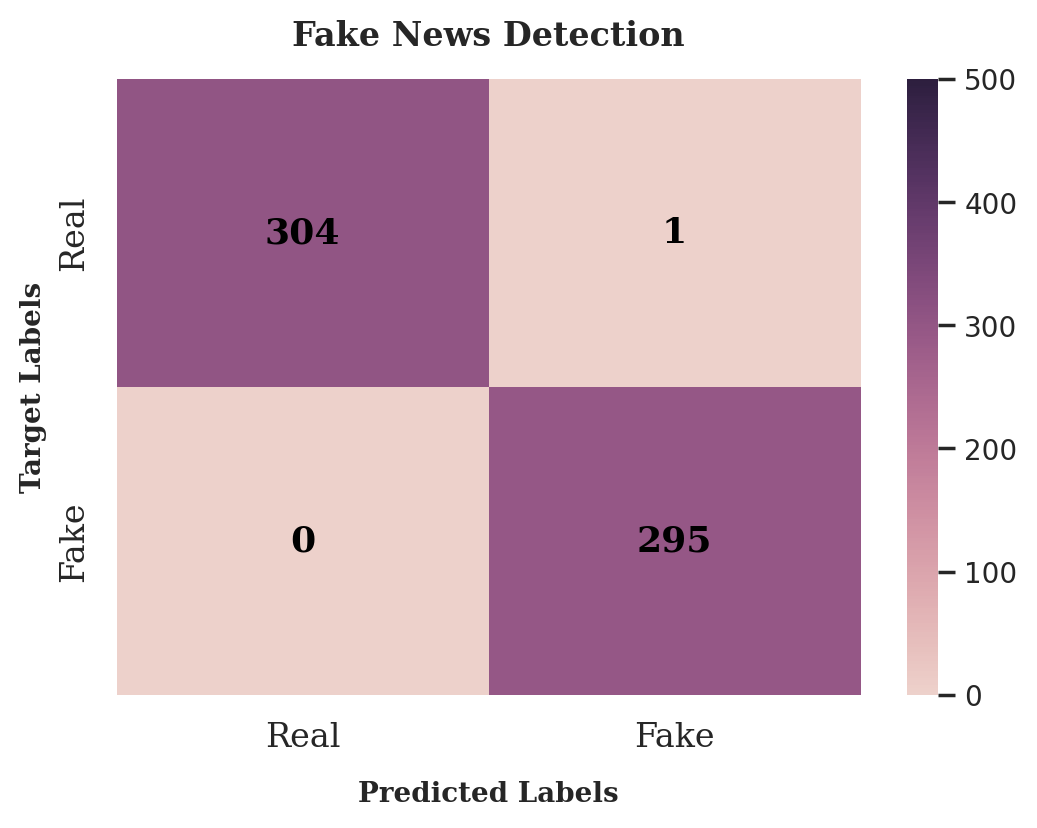

In [244]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)



# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.cubehelix_palette( as_cmap=True)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,vmin=0,vmax=500,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('Fake News Detection', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()


# **Predicting on Text**

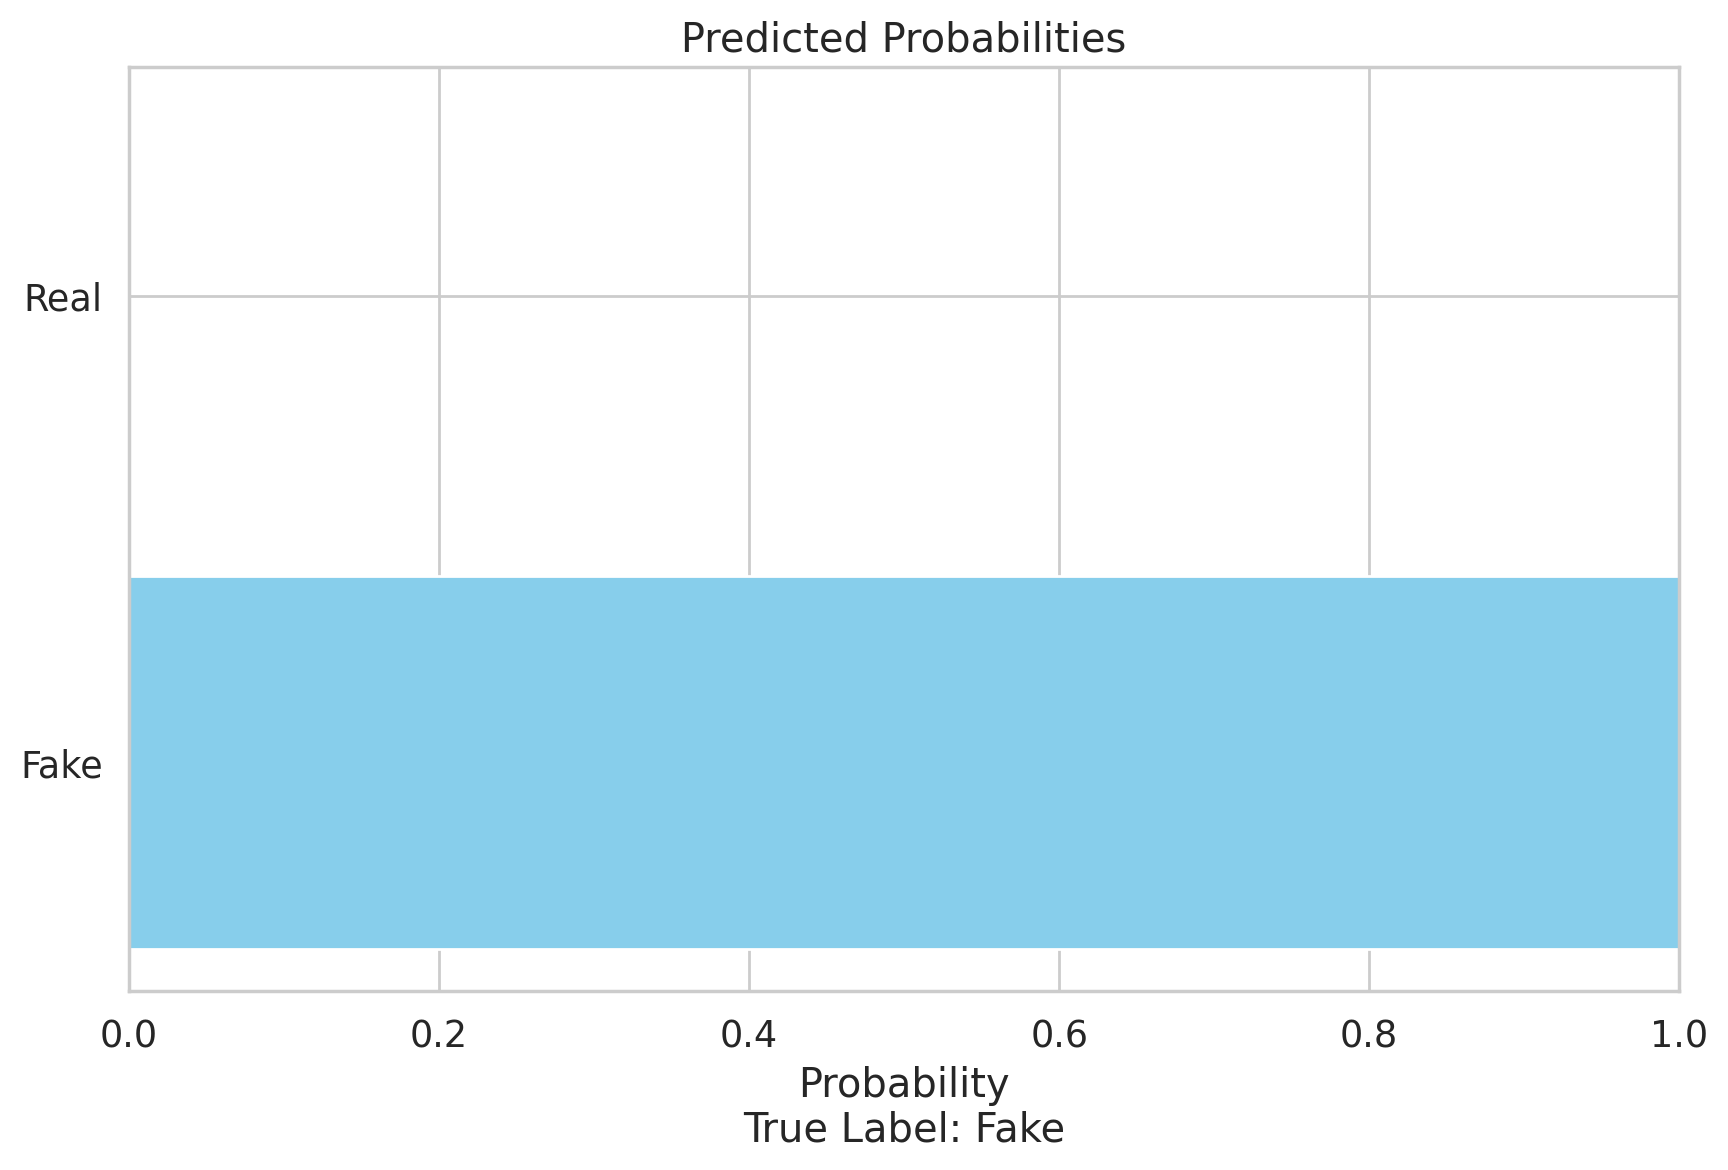

In [249]:
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import wrap

# Assuming class_names and y_pred_probs are already defined
idx = 40
review_text = y_review_texts[idx]
true_label = y_test[idx]

# Create a DataFrame for visualization
pred_df = pd.DataFrame({
    'Class Names': class_names,
    'Probabilities': y_pred_probs[idx]
})

# Sort the DataFrame by probabilities in descending order
pred_df = pred_df.sort_values(by='Probabilities', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(pred_df['Class Names'], pred_df['Probabilities'], color='skyblue')
plt.xlabel('Probability')
plt.title('Predicted Probabilities')
plt.xlim(0, 1)  # Set x-axis limit to be between 0 and 1



# Display true label
plt.text(0.5, -0.15, f'True Label: {class_names[true_label]}', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()


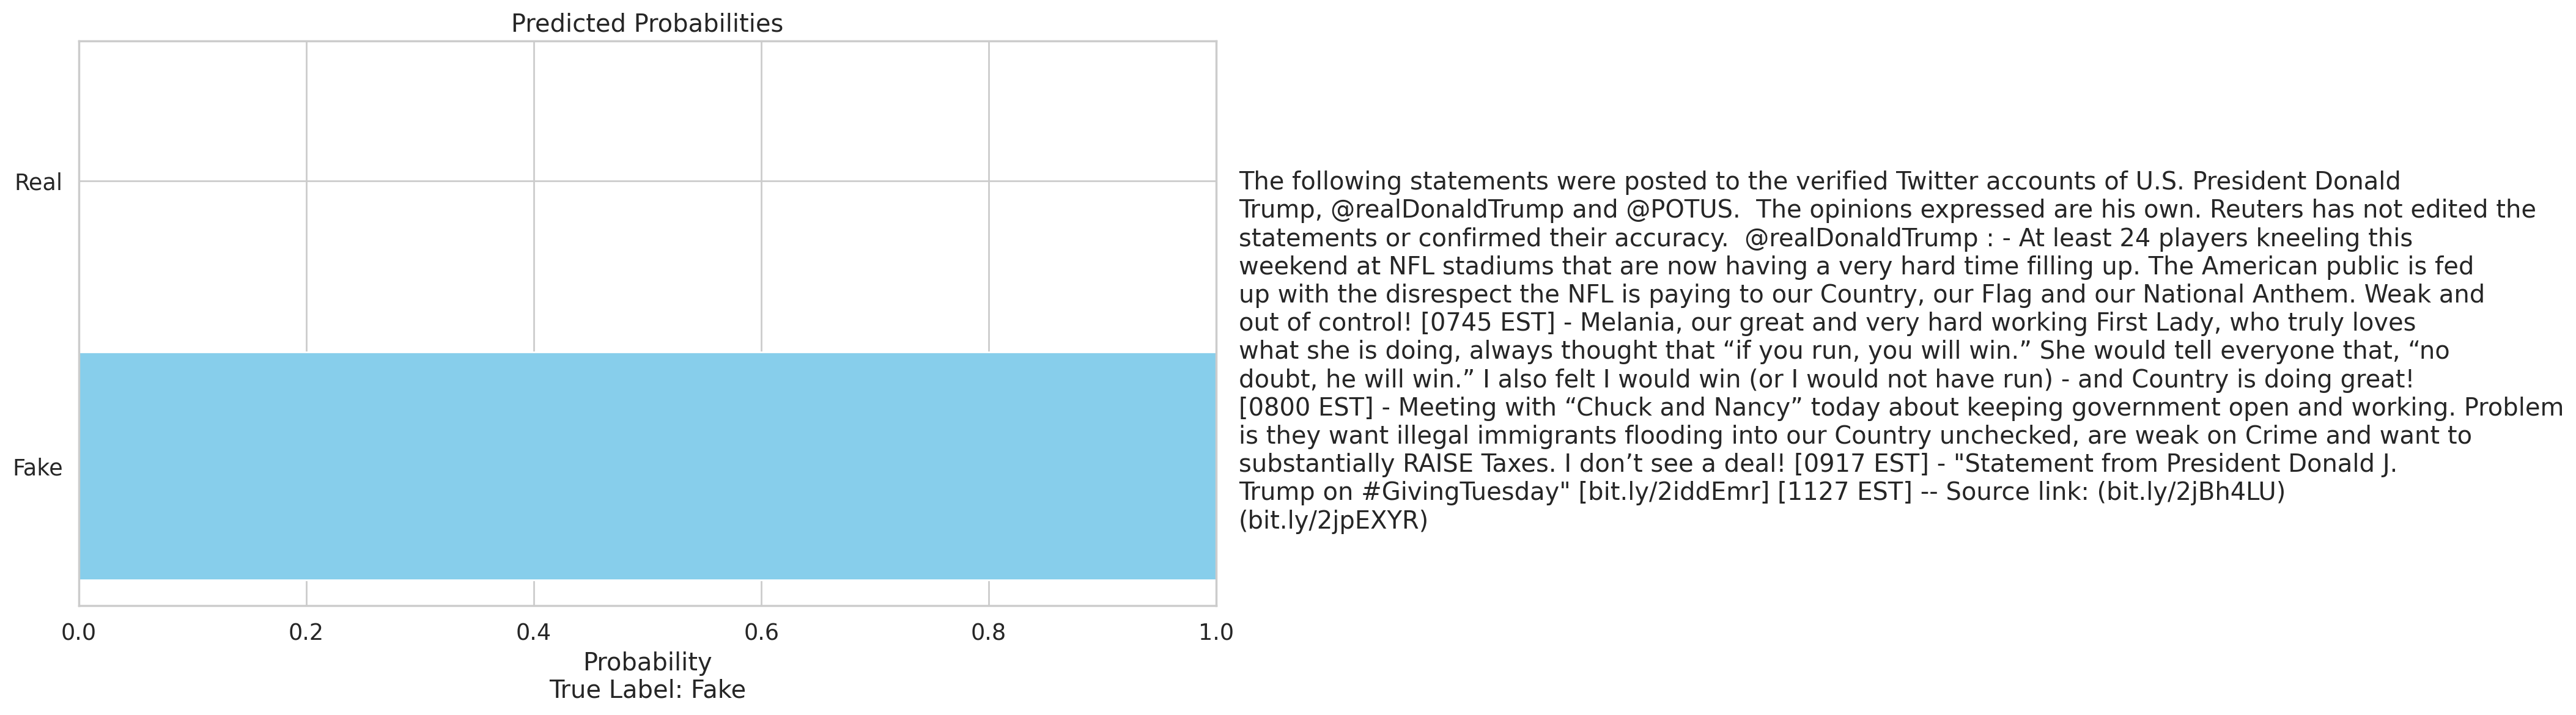

In [276]:
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import wrap

# Assuming class_names and y_pred_probs are already defined
idx = 40
review_text = y_review_texts[idx]
true_label = y_test[idx]

# Create a DataFrame for visualization
pred_df = pd.DataFrame({
    'Class Names': class_names,
    'Probabilities': y_pred_probs[idx]
})

# Sort the DataFrame by probabilities in descending order
pred_df = pred_df.sort_values(by='Probabilities', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
bars = plt.barh(pred_df['Class Names'], pred_df['Probabilities'], color='skyblue')
plt.xlabel('Probability')
plt.title('Predicted Probabilities')
plt.xlim(0, 1)  # Set x-axis limit to be between 0 and 1

# Display true label
plt.text(0.5, -0.15, f'True Label: {class_names[true_label]}', ha='center', va='center', transform=plt.gca().transAxes)

# Display review_text on the right side of the bars
text_displayed = False
for bar, label, prob in zip(bars, pred_df['Class Names'], pred_df['Probabilities']):
    if not text_displayed:
        plt.text(prob + 0.02, bar.get_y() + bar.get_height(), '\n'.join(wrap(review_text,100)), ha='left', va='center')
        text_displayed = True

plt.show()


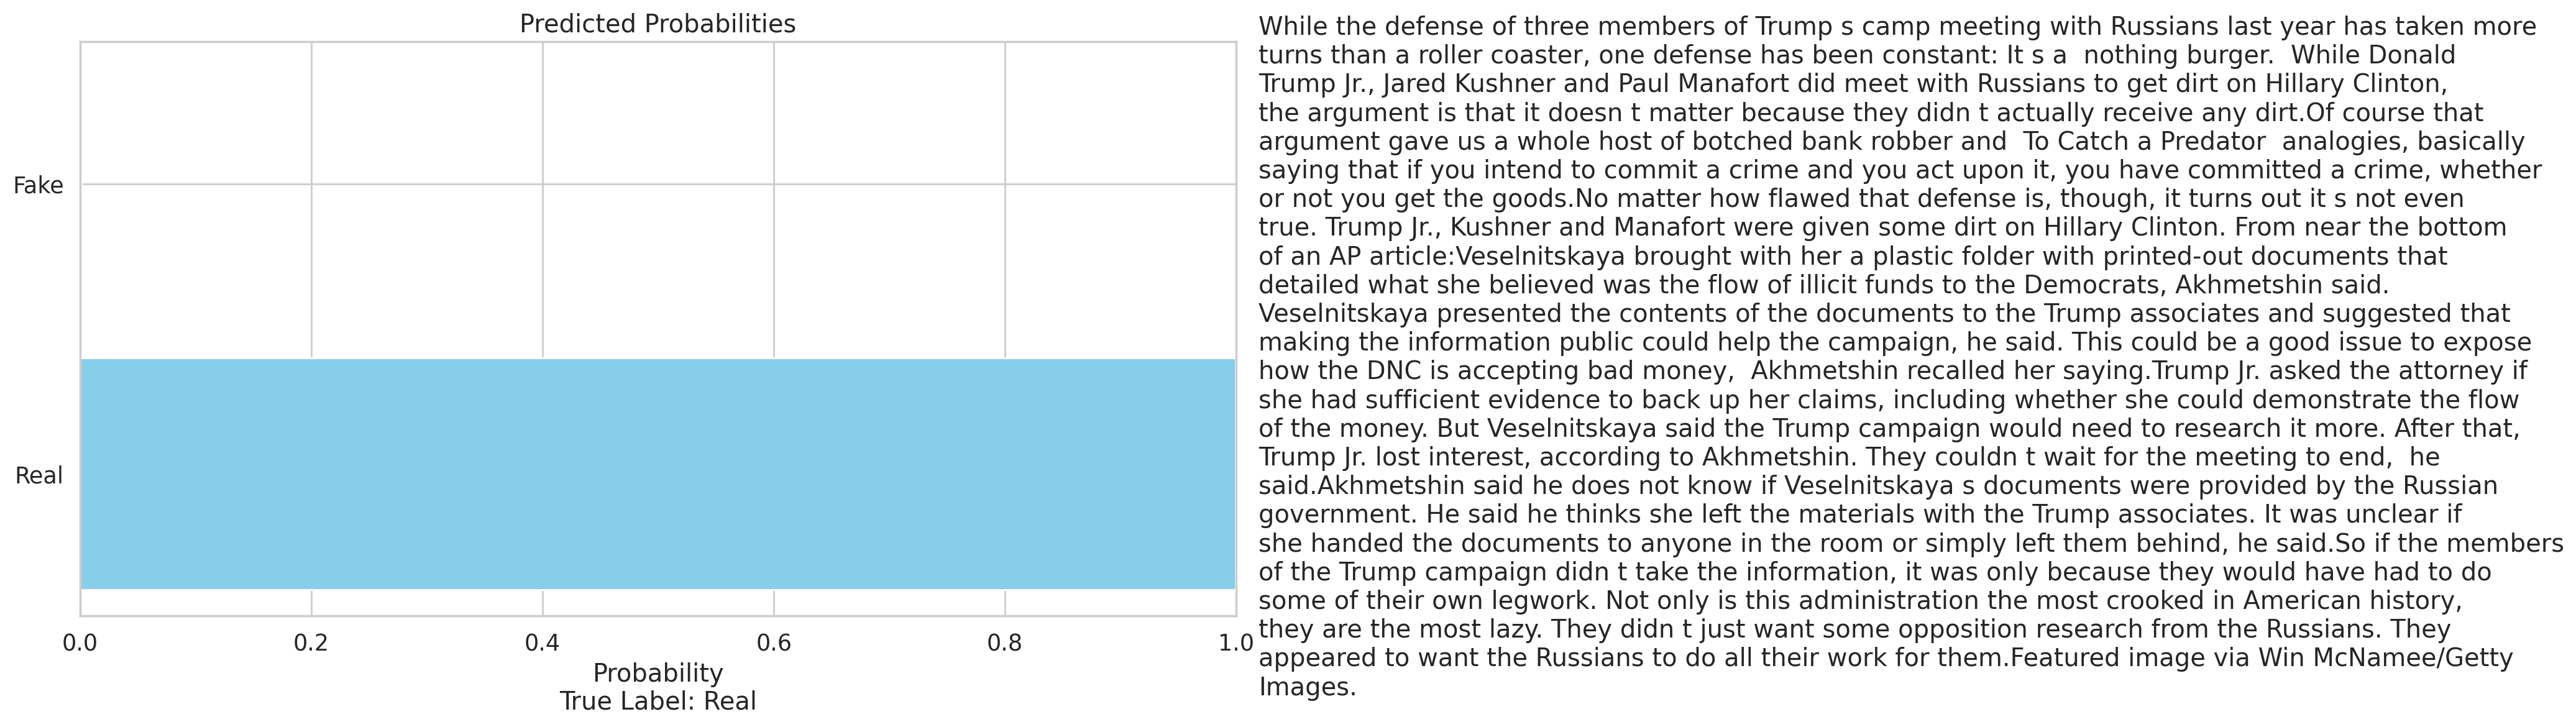

In [277]:
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import wrap

# Assuming class_names and y_pred_probs are already defined
idx = 50
review_text = y_review_texts[idx]
true_label = y_test[idx]

# Create a DataFrame for visualization
pred_df = pd.DataFrame({
    'Class Names': class_names,
    'Probabilities': y_pred_probs[idx]
})

# Sort the DataFrame by probabilities in descending order
pred_df = pred_df.sort_values(by='Probabilities', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
bars = plt.barh(pred_df['Class Names'], pred_df['Probabilities'], color='skyblue')
plt.xlabel('Probability')
plt.title('Predicted Probabilities')
plt.xlim(0, 1)  # Set x-axis limit to be between 0 and 1

# Display true label
plt.text(0.5, -0.15, f'True Label: {class_names[true_label]}', ha='center', va='center', transform=plt.gca().transAxes)

# Display review_text on the right side of the bars
text_displayed = False
for bar, label, prob in zip(bars, pred_df['Class Names'], pred_df['Probabilities']):
    if not text_displayed:
        plt.text(prob + 0.02, bar.get_y() + bar.get_height(), '\n'.join(wrap(review_text,100)), ha='left', va='center')
        text_displayed = True

plt.show()
